In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np

## Collecting Results of BDistricting

In [2]:
counties = [
    'adams',
    'allegheny',
    'armstrong',
    'beaver',
    'bedford',
    'berks',
    'blair',
    'bradford',
    'bucks',
    'butler',
    'cambria',
    'cameron',
    'carbon',
    'centre',
    'chester',
    'clarion',
    'clearfield',
    'clinton',
    'columbia',
    'crawford',
    'cumberland',
    'dauphin',
    'delaware',
    'elk',
    'erie',
    'fayette',
    'forest',
    'franklin',
    'fulton',
    'greene',
    'huntingdon',
    'indiana',
    'jefferson',
    'juniata',
    'lackawanna',
    'lancaster',
    'lawrence',
    'lebanon',
    'lehigh',
    'luzerne',
    'lycoming',
    'mckean',
    'mercer',
    'mifflin',
    'monroe',
    'montgomery',
    'montour',
    'northampton',
    'northumberland',
    'perry',
    'philadelphia',
    'pike',
    'potter',
    'schuylkill',
    'snyder',
    'somerset',
    'sullivan',
    'susquehanna',
    'tioga',
    'union',
    'venango',
    'warren',
    'washington',
    'wayne',
    'westmoreland',
    'wyoming',
    'york'
]

In [3]:
PA_Bdistrict_out = pd.read_csv('data/PA_Congress.csv')
PA_Bdistrict_out = PA_Bdistrict_out.set_index('FULLCODE')
PA_Bdistrict_out = PA_Bdistrict_out.loc[:, ~PA_Bdistrict_out.columns.str.contains('^Unnamed')]
PA_Bdistrict_out.head()

,DISTRICT
FULLCODE,
420010301011000,4
420010301011001,4
420010301011002,4
420010301011003,4
420010301011004,4


In [4]:
# Define dataframe to carry all PA info
df = pd.DataFrame({'VTD': []})

# Helper function for VTD
def convert_vtd_type(obj):
    if type(obj) is not str:
        return format(int(obj), '06d')
    return obj

for i in range(1, 68):
    # Convert step into county fips string
    num = i*2 - 1
    county_fips = format(num, '03d')
    
    # define dataframe from the census block data from county specified by
    # county_fips
    url = f'https://www2.census.gov/geo/maps/DC2020/PL20/st42_pa/censusblock_maps/c42{county_fips}_{counties[i-1]}/PL20BLK_C42{county_fips}_BLK2MS.txt'
    subdf = pd.read_csv(url, sep=';')
    subdf = subdf.set_index('FULLCODE')

    # Remove useless columns
    subdf = subdf.drop(columns=['TYPE', 'STATE', 'COUNTY','TRACT', 'BLOCK', 'PLACE', 'COUSUB', 'CONCITY', 'AIANHHL', 'SLDU', 'SLDL', 'SHEETS'])
    
    # If VTD is not a string, convert it to one
    subdf['VTD'] = subdf['VTD'].apply(lambda x: convert_vtd_type(x))

    # Concatenate subdf to df
    df = pd.concat([df, subdf])

df.head()

,VTD
420010301011000,000310
420010301011001,000310
420010301011002,000310
420010301011003,000310
420010301011004,000310


In [5]:
# Merging two dataframes
df_final = pd.merge(PA_Bdistrict_out, df, left_index=True, right_index=True)
# Adding column to correspond with GEOID20 in gdf (see section below)
df_final['GEOID20'] = df_final.index.map(lambda s: str(s)[:5]) + df_final['VTD']
df_final.head()

,DISTRICT,VTD,GEOID20
FULLCODE,,,
420010301011000,4,000310,42001000310
420010301011001,4,000310,42001000310
420010301011002,4,000310,42001000310
420010301011003,4,000310,42001000310
420010301011004,4,000310,42001000310


This final dataframe at the end contains four columns:
- `FULLCODE`: a column representing each individual census block,
- `DISTRICT`: a column representing the district to which it belongs to according to the BDistricting algorithm, and
- `VTD`: a column representing which voting district it belongs to
- `GEOID20`: a column which has both the state code, county code, and VTD ID in one string

## Visualizing Voting Districts

In [6]:
# All credit for these Shapefiles goes to the MGGG Redistricting Lab and their collection of repositories where they
# maintain shapefiles for most of the US states
gdf = gpd.read_file('data/PA_pop/PA_pop.shp')

In [7]:
gdf.head()

,GEOID20,G18GOVRWAG,G18USSDCAS,NAME,G18USSLKER,VTDST,STATEFP,G18USSGGAL,COUNTYFP,G18USSRBAR,...,AMINPOP10,BCVAP19,BPOP19,BPOP10,NHPIPOP10,WPOP19,WCVAP19,WPOP10,CVAP19,geometry
0,42001000010,185.0,120.0,ABBOTTSTOWN,5.0,000010,42,2.0,001,183.0,...,1.0,0.000000,0.000000,14.0,0.0,865.737199,620.903614,937.0,661.066098,"POLYGON ((664343.521 -31159.417, 664394.941 -3..."
1,42001000020,172.0,151.0,ARENDTSVILLE,6.0,000020,42,3.0,001,178.0,...,5.0,3.857143,7.714286,27.0,0.0,656.233129,518.588957,790.0,559.141982,"POLYGON ((637504.270 -26605.813, 638030.307 -2..."
2,42001000030,98.0,74.0,BENDERSVILLE,1.0,000030,42,2.0,001,103.0,...,7.0,32.352941,38.823529,11.0,0.0,568.033908,392.635336,541.0,472.758530,"POLYGON ((642210.643 -20528.243, 642237.216 -2..."
3,42001000040,554.0,289.0,BERWICK,14.0,000040,42,5.0,001,575.0,...,3.0,70.000000,75.000000,59.0,0.0,2099.817018,1706.445783,2208.0,1880.963042,"MULTIPOLYGON (((664548.709 -30805.093, 664784...."
4,42001000050,215.0,152.0,BIGLERVILLE,3.0,000050,42,7.0,001,231.0,...,1.0,7.153846,14.538462,10.0,0.0,1012.662149,814.375469,1100.0,886.786844,"POLYGON ((642244.314 -26116.364, 642318.415 -2..."


In [8]:
# Get rid of Lake Erie census block
gdf = gdf[gdf['NAME'] != 'LAKE ERIE']

In [9]:
# Merge gdf and df_final to combine BDistricts output and census data
gdf_final = pd.merge(gdf, df_final, on='GEOID20', how='inner')
gdf_final = gdf_final.drop_duplicates()
gdf_final.head()

,GEOID20,G18GOVRWAG,G18USSDCAS,NAME,G18USSLKER,VTDST,STATEFP,G18USSGGAL,COUNTYFP,G18USSRBAR,...,BPOP19,BPOP10,NHPIPOP10,WPOP19,WCVAP19,WPOP10,CVAP19,geometry,DISTRICT,VTD
0,42001000010,185.0,120.0,ABBOTTSTOWN,5.0,000010,42,2.0,001,183.0,...,0.000000,14.0,0.0,865.737199,620.903614,937.0,661.066098,"POLYGON ((664343.521 -31159.417, 664394.941 -3...",4,000010
48,42001000020,172.0,151.0,ARENDTSVILLE,6.0,000020,42,3.0,001,178.0,...,7.714286,27.0,0.0,656.233129,518.588957,790.0,559.141982,"POLYGON ((637504.270 -26605.813, 638030.307 -2...",4,000020
68,42001000030,98.0,74.0,BENDERSVILLE,1.0,000030,42,2.0,001,103.0,...,38.823529,11.0,0.0,568.033908,392.635336,541.0,472.758530,"POLYGON ((642210.643 -20528.243, 642237.216 -2...",4,000030
94,42001000040,554.0,289.0,BERWICK,14.0,000040,42,5.0,001,575.0,...,75.000000,59.0,0.0,2099.817018,1706.445783,2208.0,1880.963042,"MULTIPOLYGON (((664548.709 -30805.093, 664784....",4,000040
143,42001000050,215.0,152.0,BIGLERVILLE,3.0,000050,42,7.0,001,231.0,...,14.538462,10.0,0.0,1012.662149,814.375469,1100.0,886.786844,"POLYGON ((642244.314 -26116.364, 642318.415 -2...",4,000050


In [10]:
gdf_final['area'] = gdf_final.area
gdf_final['area']

0         1.434856e+06
48        2.075181e+06
68        1.170411e+06
94        2.010292e+07
143       1.692140e+06
              ...     
336852    2.213574e+06
336870    4.892537e+06
336902    5.369318e+05
336913    8.410837e+05
336945    4.442498e+05
Name: area, Length: 9687, dtype: float64

<Axes: >

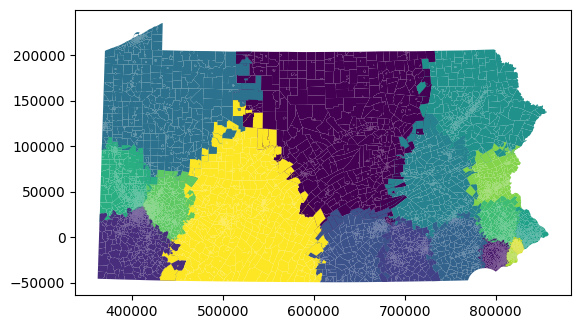

In [11]:
gdf_final.plot(column='DISTRICT')

## Racial Concentration and Voting Pattern Analysis

For this part of the analysis, we are looking for a Black opportunity district, which is one where Black people have a significant coersion on the vote. We define a Black opportunity district as one where the majority of voters in a district is Black and one where the district will reliably elect a representative of the minority preferred party (MPP). We first check for the existence of a minority-preferred party (MPP) by looking at majority-Black districts and observing their voting pattern. If there is an MPP, we will continue to look for Black opportunity districts.

In [41]:
# Checking the percentage of Black people in the population of Pennsylvania
BPOP_total = np.round(sum(gdf_final['BPOP19']))
POP_total  = np.round(sum(gdf_final['NHPOP19']))
BPOP_total, BPOP_total/POP_total

(1487623.0, 0.11704193436893964)

There are just under 1.5 million Black people in Pennsylvania, making up about 11.7% of the population.

<Axes: >

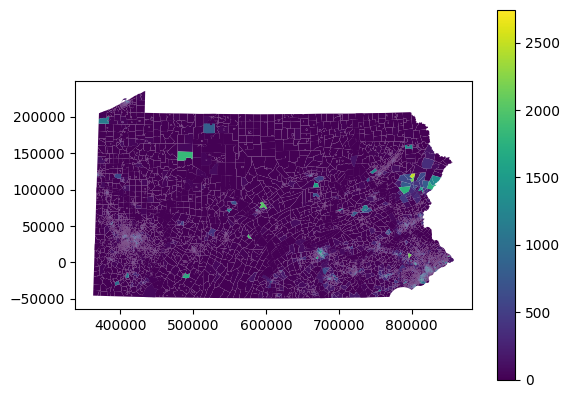

In [19]:
# Plotting all VTDs by Black population
gdf_final.plot(column='BPOP19', legend=True)

c:\Users\Neel Dhulipala\OneDrive\Desktop\AdvAlgs\PA_voting_districts\dist_env\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\Neel Dhulipala\OneDrive\Desktop\AdvAlgs\PA_voting_districts\dist_env\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<Axes: title={'center': 'Presidential Results on Majority-Black Districts'}, xlabel='BWratio', ylabel='DRratio'>

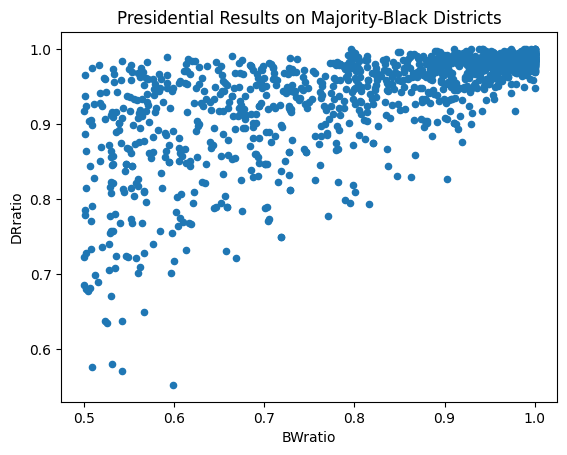

In [27]:
# Create dataframe where every row includes a VTD with more Blacks than Whites
gdf_maj_min_vtds = gdf_final[gdf_final['BPOP19'] >= gdf_final['WPOP19']]
gdf_maj_min_vtds['BWratio'] = gdf_maj_min_vtds['BPOP19'] / (gdf_maj_min_vtds['BPOP19'] + gdf_maj_min_vtds['WPOP19'])
# Party concentration
gdf_maj_min_vtds['DRratio'] = gdf_maj_min_vtds['G16PREDCLI'] / (gdf_maj_min_vtds['G16PREDCLI'] + gdf_maj_min_vtds['G16PRERTRU'])
# Plot both columns
gdf_maj_min_vtds.plot(x='BWratio', y='DRratio', kind='scatter', title='Presidential Results on Majority-Black Districts')

c:\Users\Neel Dhulipala\OneDrive\Desktop\AdvAlgs\PA_voting_districts\dist_env\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<Axes: title={'center': 'Governor Results on Majority-Black Districts'}, xlabel='BWratio', ylabel='DRratio_gov'>

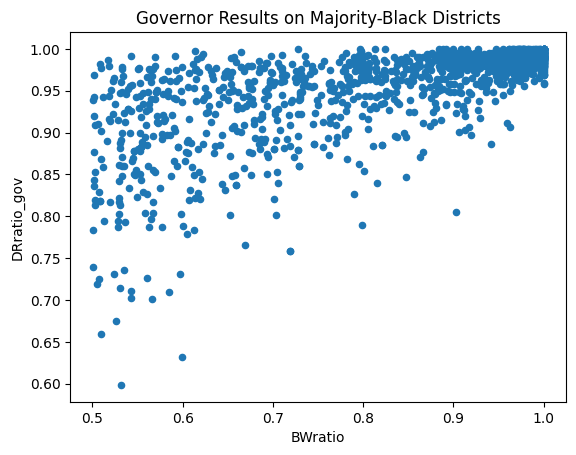

In [28]:
# Party concentration
gdf_maj_min_vtds['DRratio_gov'] = gdf_maj_min_vtds['G18GOVDWOL'] / (gdf_maj_min_vtds['G18GOVDWOL'] + gdf_maj_min_vtds['G18GOVRWAG'])
# Plot both columns
gdf_maj_min_vtds.plot(x='BWratio', y='DRratio_gov', kind='scatter', title='Governor Results on Majority-Black Districts')

From the plot above, we see that voting districts with more black voters tend to vote for the Democratic candidate in both the 2016 Presidential race and the 2018 Governor race. This displays a correlation between minority voters and Democratic-swinging districts. This supports the idea presented in this [NYTimes article](https://www.nytimes.com/interactive/2020/11/03/us/elections/ap-polls-pennsylvania.html) that Black voters vote Democrat, hence making the Democratic Party the MPP.

According to [this MIT paper](https://mit-serc.pubpub.org/pub/algorithmic-redistricting-in-us-elections/release/1), a Black opportunity district is one where a district reliably will vote for the MPP candidate (in this case, the Democrat) and is majority Black. Does that exist in Pennsylvania?

In [49]:
# Only care about the population columns so we can group by Congressional Districts and sum
gdf_pops = gdf_final.drop(['geometry'], axis=1)
gdf_pops = gdf_pops.groupby('DISTRICT').sum()

# Calculate population of Blacks in each district
gdf_pops['BPOP19'] / (gdf_pops['NHPOP19'])

DISTRICT
0     0.027834
1     0.133658
2     0.059087
3     0.067174
4     0.092838
5     0.063250
6     0.041228
7     0.041273
8     0.066604
9     0.077690
10    0.068908
11    0.065532
12    0.124974
13    0.075453
14    0.524351
15    0.536956
16    0.023699
dtype: float64

We can see that Districts 14 and 15 are two majority-Black districts by slim margins, which makes them the two districts qualified to be Black opportunity districts. Let's look at the voting data of those two districts.

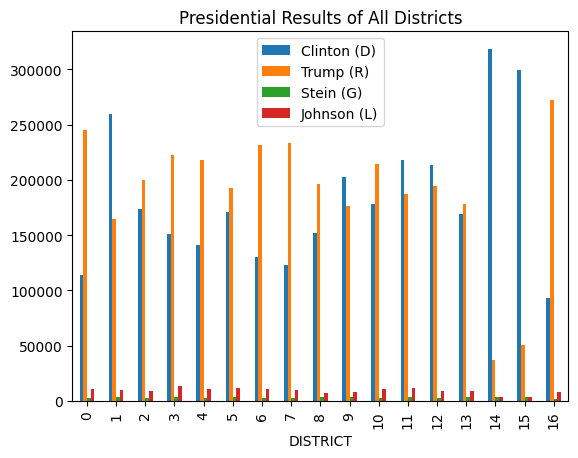

In [73]:
ax = gdf_pops.plot(y=['G16PREDCLI', 'G16PRERTRU', 'G16PREGSTE', 'G16PRELJOH'], kind='bar', use_index=True, title='Presidential Results of All Districts')
ax.legend(['Clinton (D)', 'Trump (R)', 'Stein (G)', 'Johnson (L)'])

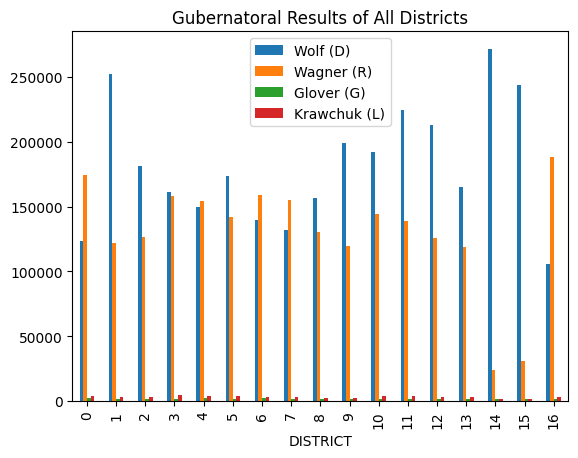

In [81]:
ax2 = gdf_pops.plot(y=['G18GOVDWOL', 'G18GOVRWAG', 'G18GOVGGLO', 'G18GOVLKRA'], kind='bar', use_index=True, title='Gubernatoral Results of All Districts')
ax2.legend(['Wolf (D)', 'Wagner (R)', 'Glover (G)', 'Krawchuk (L)'])

Visually speaking, while some of the other districts flip parties between the Presidential and Governor cycle, Districts 14 and 15 are strongly Democrat-leaning. By the definition of opportunity districts, that means both 14 and 15 are Black opportunity districts, especially since it is apparent that the non-Black voters in those districts are also voting with the Black voters. Therefore, in the BDistricting output, there are two Black opportunity districts out of the 17 districts. This means that 11.7% of the congressional districts represent Black voters the most significantly, which is equal to the proportion of Black people in Pennsylvania.